In [4]:
#take two (also like, technically my 5th try bc I've come back after some other testing collabs. haha)!
#following along: https://keras.io/guides/transfer_learning/ because I'm trying not to be stubborn.
#and using the same 102 oxford flowers dataset but through tensorflow databases instead of from kaggle.

In [5]:
#going to try and keep all my import libraries in one place.
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
from tensorflow import data as tf_data

In [6]:
test_ds, valid_ds, train_ds = tfds.load('oxford_flowers102', split = ['train', 'validation', 'test'],  as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.9K4LOX_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.9K4LOX_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.9K4LOX_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [7]:
print(f"Number of training samples: {train_ds.cardinality()}")  #swapping test and train def fixed the evaluation from 50% to 75%
print(f"Number of validation samples: {valid_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 6149
Number of validation samples: 1020
Number of test samples: 1020


In [8]:
#flowers_ds, info = tfds.load('oxford_flowers102', split='train', with_info=True)

#tfds.as_dataframe(flowers_ds.take(4), info) #these numbers and names match up

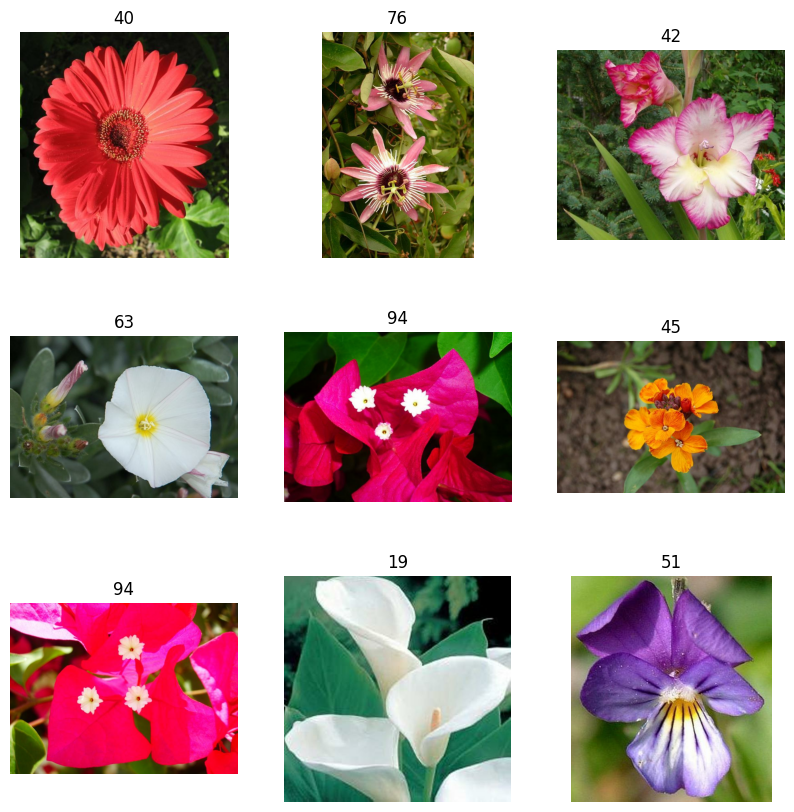

In [9]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label)) #wait omg the kaggle list is one off number wise for the labels huh.
    plt.axis("off") #ref this for labels, a helpful tool which may be useful later: https://www.kaggle.com/datasets/hobaak/oxford-102-flower-name-index

In [10]:
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {valid_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 6149
Number of validation samples: 1020
Number of test samples: 1020


In [11]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
valid_ds = valid_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [12]:
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {valid_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 6149
Number of validation samples: 1020
Number of test samples: 1020


In [13]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [14]:
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {valid_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 6149
Number of validation samples: 1020
Number of test samples: 1020


In [15]:
batch_size = 8 # prev 16 #smaller batch sizes leaves me more in each dataset

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
valid_ds = valid_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

In [16]:
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {valid_ds.cardinality()}") #this feels better I think, given there's 102 classes in this ds
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 769
Number of validation samples: 128
Number of test samples: 128


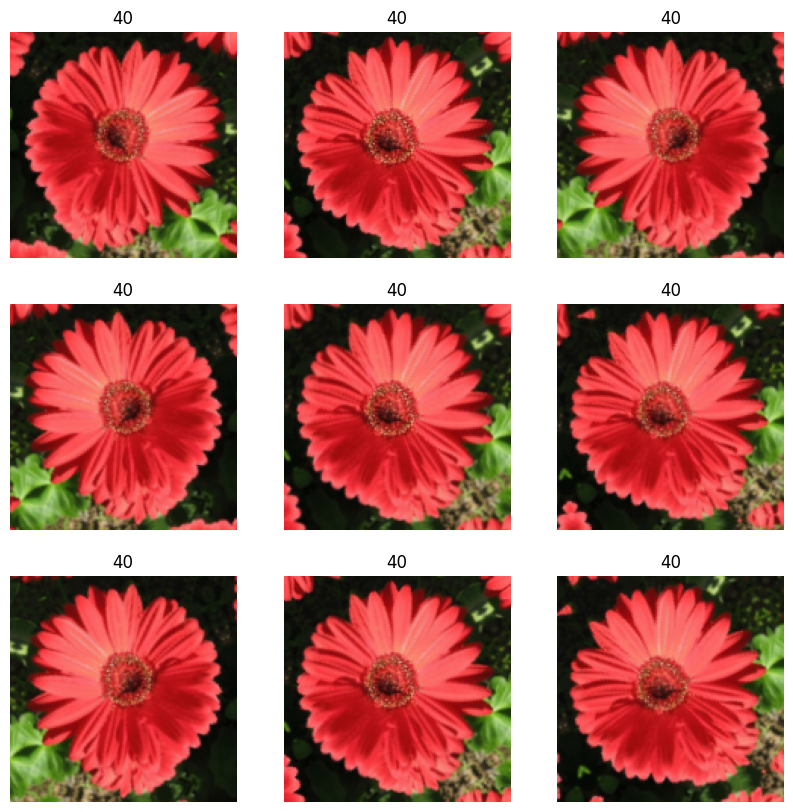

In [17]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [18]:
base_model = keras.applications.Xception( #Xeception bc it's apparently better than ResNet50 at image classification
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top. < this stops this from just being an imagenet classifier.

# Freeze the base_model
base_model.trainable = False

#in theory: I could add this in to try and improve performance, but given my current restriction from google colab gpu, I can't test it
# un-freeze the BatchNorm layers (bc this is a common issue for transfer learning. https://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/)
#for layer in base_model.layers:
#    if "BatchNormalization" in layer.__class__.__name__:
#        layer.trainable = True

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3)) #This matches the input shape of the Xception base model.

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1) #this does the rescaling.
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False) #take in input, rescales, and puts it through some layers of xception...
x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x) #inserting layers from https://keras.io/examples/vision/image_classification_from_scratch/? to try and improve performance
x = layers.Activation("relu")(x)
x = keras.layers.GlobalAveragePooling2D()(x) #downsampling the image, but preserve the information
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(102, activation='softmax')(x) #I have 102 classes compared to the binary classification of this example, just going to change this to 102 and hope it works?
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ separable_conv2d (SeparableConv2D)  │ (None, 5, 5, 1024)           │     2,116,608 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_4               │ (None, 5, 5, 1024)           │         4,096 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation (Activation)             │ (None, 5, 5, 1024)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1024)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1024)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 102)                  │       104,550 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 23,086,734 (88.07 MB)

 Trainable params: 2,223,206 (8.48 MB)

 Non-trainable params: 20,863,528 (79.59 MB)

In [19]:
#keras.utils.plot_model(model, show_shapes=True) #this visualization comes from here: https://keras.io/examples/vision/image_classification_from_scratch/

In [20]:
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {valid_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 769
Number of validation samples: 128
Number of test samples: 128


In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), #change from a binary crossentropy to one that can accept more labels, also number based.
    metrics=[keras.metrics.SparseCategoricalAccuracy()], #similarly swap this out, matching the loss function.
)

epochs = 10 #prev 15
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=valid_ds) #now it's dropping val accuracy before 10... is 5 the best?

Fitting the top layer of the model
Epoch 1/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 875s 1s/step - loss: 2.8333 - sparse_categorical_accuracy: 0.3750 - val_loss: 1.1702 - val_sparse_categorical_accuracy: 0.6578
Epoch 2/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 813s 1s/step - loss: 0.8113 - sparse_categorical_accuracy: 0.7958 - val_loss: 0.9214 - val_sparse_categorical_accuracy: 0.7353
Epoch 3/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 831s 1s/step - loss: 0.3304 - sparse_categorical_accuracy: 0.9377 - val_loss: 0.8811 - val_sparse_categorical_accuracy: 0.7618
Epoch 4/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 861s 1s/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.8551 - val_sparse_categorical_accuracy: 0.7657
Epoch 5/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 873s 1s/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.8487 - val_sparse_categorical_accuracy: 0.7833
Epoch 6/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 830s 1s/step - loss: 0.0220 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.8516 - val

In [22]:
print("Test dataset evaluation")
model.evaluate(test_ds) #why does this consistently suck?

Test dataset evaluation
128/128 ━━━━━━━━━━━━━━━━━━━━ 108s 839ms/step - loss: 1.2417 - sparse_categorical_accuracy: 0.7315


[1.1569732427597046, 0.7392156720161438]

In [25]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

epochs = 25
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ separable_conv2d (SeparableConv2D)  │ (None, 5, 5, 1024)           │     2,116,608 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_4               │ (None, 5, 5, 1024)           │         4,096 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ activation (Activation)             │ (None, 5, 5, 1024)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 1024)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 1024)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 102)                  │       104,550 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 69,147,052 (263.78 MB)

 Trainable params: 23,030,158 (87.85 MB)

 Non-trainable params: 56,576 (221.00 KB)

 Optimizer params: 46,060,318 (175.71 MB)

Fitting the end-to-end model
Epoch 1/25
769/769 ━━━━━━━━━━━━━━━━━━━━ 2924s 4s/step - loss: 2.0335 - sparse_categorical_accuracy: 0.5049 - val_loss: 1.9969 - val_sparse_categorical_accuracy: 0.5706
Epoch 2/25
769/769 ━━━━━━━━━━━━━━━━━━━━ 2916s 4s/step - loss: 0.5698 - sparse_categorical_accuracy: 0.8551 - val_loss: 1.7419 - val_sparse_categorical_accuracy: 0.6176
Epoch 3/25
769/769 ━━━━━━━━━━━━━━━━━━━━ 2860s 4s/step - loss: 0.2117 - sparse_categorical_accuracy: 0.9656 - val_loss: 1.6861 - val_sparse_categorical_accuracy: 0.6382
Epoch 4/25
769/769 ━━━━━━━━━━━━━━━━━━━━ 2793s 4s/step - loss: 0.0825 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.6456 - val_sparse_categorical_accuracy: 0.6559
Epoch 5/25
769/769 ━━━━━━━━━━━━━━━━━━━━ 2781s 4s/step - loss: 0.0401 - sparse_categorical_accuracy: 0.9998 - val_loss: 1.6313 - val_sparse_categorical_accuracy: 0.6618
Epoch 6/25
151/769 ━━━━━━━━━━━━━━━━━━━━ 37:50 4s/step - loss: 0.0214 - sparse_categorical_accuracy: 1.0000

KeyboardInterrupt: 

In [26]:
print("Test dataset evaluation")
model.evaluate(test_ds) #why does this consistently suck? it got better this time at least? extra layers helping? worse now.

Test dataset evaluation
128/128 ━━━━━━━━━━━━━━━━━━━━ 100s 786ms/step - loss: 1.8589 - sparse_categorical_accuracy: 0.6324


[1.822765588760376, 0.6294117569923401]

In [27]:
score = model.evaluate(test_ds, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.822765588760376 / Test accuracy: 0.6294117569923401


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[2.05067138e-07 6.32021813e-09 4.69493111e-10 1.22427593e-07
  9.85783988e-09 1.46804924e-08 4.30192046e-07 1.46171795e-08
  9.67450786e-10 3.53193530e-10 1.40043954e-09 1.38269183e-08
  2.27429928e-06 1.22761676e-08 6.65693944e-10 7.68375727e-08
  4.46673951e-08 3.41939312e-06 5.33758140e-08 2.70493530e-07
  4.87061584e-07 1.02321502e-08 4.47884730e-07 2.39155291e-08
  1.99823935e-09 6.50163978e-10 2.06360363e-11 7.97614697e-10
  1.09170927e-07 6.05785200e-09 6.03379702e-09 1.11532202e-07
  6.13696871e-09 4.78923354e-08 3.74871939e-10 1.65879666e-08
  2.25836683e-09 9.02816655e-10 1.67745020e-05 2.49173212e-07
  2.80625070e-08 1.24047347e-07 4.54656615e-08 9.99329330e-09
  1.66439776e-07 1.21072778e-08 1.42549994e-09 1.00627851e-07
  8.63095728e-09 5.45179624e-10 2.02152783e-09 8.40388793e-07
  6.82664052e-07 2.97788034e-08 1.95010159e-08 9.36684952e-09
  2.18476828e-08 3.81548348e-09 2.26199770e-08 3.71497784e-08
  4.72291051e-09 3.05889262e-06 5.

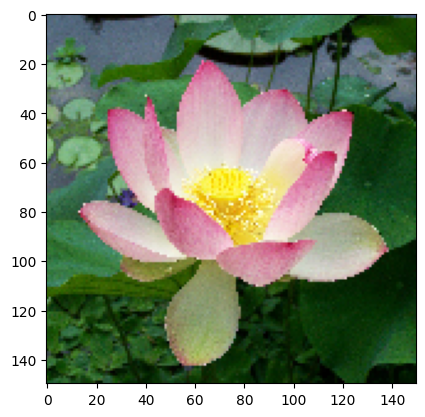

In [28]:
input_shape=(150, 150, 3) #used this to help figure out how to load an image to test: https://keras.io/examples/vision/image_classification_from_scratch/
img = keras.utils.load_img("/content/drive/MyDrive/flowers/lotus.jpg", target_size=input_shape) #mounted google drive to access some test images I googled and saved.
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions)

In [29]:
classes = np.argmax(predictions, axis = 1) #using this for help to figure out how to use my model's prediction: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-predict-new-samples-with-your-keras-model.md
print(classes)

[77]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
[93]


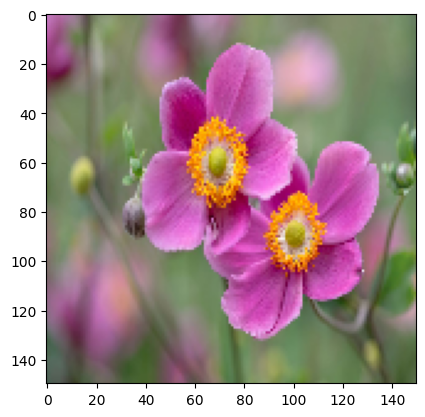

In [30]:
input_shape=(150, 150, 3)
img = keras.utils.load_img("/content/drive/MyDrive/flowers/japanese_anemone.jpg", target_size=input_shape)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
classes = np.argmax(predictions, axis = 1)
print(classes)

In [31]:
#model.save('102flowerClassifier.keras') #tried to save as h5, got message back telling me to save as keras, might also just try to save this a pickle file as well
#https://neptune.ai/blog/saving-trained-model-in-python
#https://keras.io/guides/serialization_and_saving/

In [32]:
#from tensorflow.keras.models import load_model

#model = load_model('102flowerClassifier.keras')

#model.summary()

In [33]:
import pickle

model_pkl_file = "102flowersModel.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [34]:
with open(model_pkl_file, 'rb') as file:   #wait the pickle file is probably easier to load into streamlit
    model = pickle.load(file)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 5, 5, 1024)          │       2,116,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 5, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 5, 5, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 102)                 │         104,550 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,147,052 (263.78 MB)

 Trainable params: 23,030,158 (87.85 MB)

 Non-trainable params: 56,576 (221.00 KB)

 Optimizer params: 46,060,318 (175.71 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step
[93]


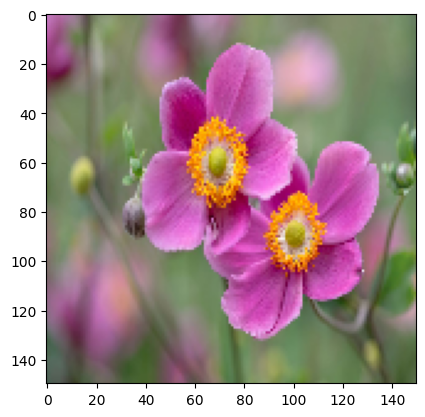

In [35]:
input_shape=(150, 150, 3)
img = keras.utils.load_img("/content/drive/MyDrive/flowers/japanese_anemone.jpg", target_size=input_shape)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

prediction = model.predict(img_array) #I think, regardless of method, I just have to set up the model's output like this then
classes = np.argmax(prediction, axis = 1)

print(classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
[97]


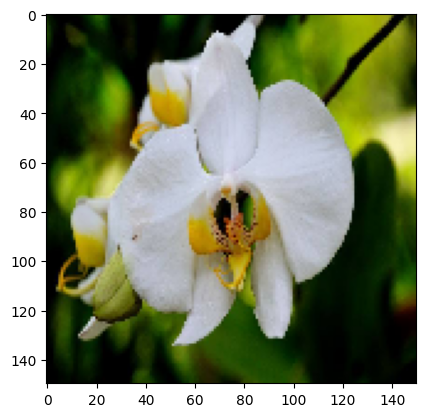

In [36]:
newimg = keras.utils.load_img("/content/drive/MyDrive/flowers/ moon_orchid.jpg", target_size=(150,150))
plt.imshow(newimg)

img_array_2 = keras.utils.img_to_array(newimg)
img_array_2 = keras.ops.expand_dims(img_array_2, 0)

prediction_2 = model.predict(img_array_2) #I think, regardless of method, I just have to set up the model's output like this then
classes_2 = np.argmax(prediction_2, axis = 1)

#wait it's correct now.

print(classes_2)  #this is wrong, fuck me, out of the 5 example flowers I picked at random to use as testing, all of them work expect for this one and 56 looks no where near this.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
[77]


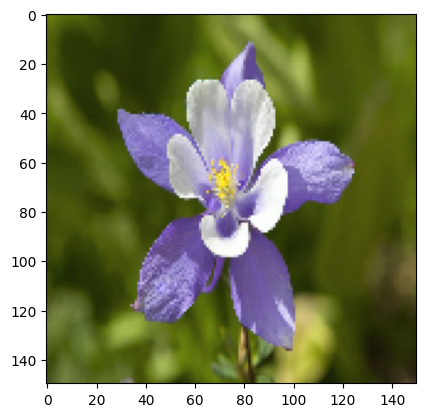

In [37]:
newimg = keras.utils.load_img("/content/drive/MyDrive/flowers/columbine.jpg", target_size=(150,150))
plt.imshow(newimg)

img_array_2 = keras.utils.img_to_array(newimg)
img_array_2 = keras.ops.expand_dims(img_array_2, 0)

prediction_2 = model.predict(img_array_2) #hm.
classes_2 = np.argmax(prediction_2, axis = 1)

print(classes_2)  #yep. wrong.  but this is still wrong.